In [8]:
from torch.utils.data import Dataset
import torch
import numpy as np
import h5py
import pytorch_lightning as pl
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch import nn
import matplotlib.pyplot as plt
import load_data as ld
import models

config = {}
config["PATH_TRAIN"] = "../data/batch1.hdf5"
data_set_conv = ld.Dataset_baseline_conv(config)

config["MODEL_NAME"] = "auto_encoder_conv"
config["in_dim"] = data_set_conv.data_in.shape[1]
config["batch_size"] = 1
config["learning_rate"] = 1e-4
config["weight_decay"] = 0
config["embedding_dim"] = 128 #int(config["in_dim"]/2)
config["hidden1_dim"] = int(config["embedding_dim"]/2)
config["hidden2_dim"] = int(config["embedding_dim"]/4)
config["encoder_dim"] = int(config["embedding_dim"]/8)
PATH = "../saves/save_auto_encoder_conv_2023-12-18/128xCPU/checkpoints/epoch=19-step=64000.ckpt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model_conv = models.model_wraper(config)
model_conv.load_state_dict(checkpoint['state_dict'])

################
config = {}
config["PATH_TRAIN"] = "../data/batch1.hdf5"
data_set = ld.Dataset_baseline(config)

config["MODEL_NAME"] = "auto_encoder"
config["in_dim"] = data_set.data_in.shape[1]
config["batch_size"] = 1
config["learning_rate"] = 1e-4
config["weight_decay"] = 0
config["embedding_dim"] = 128 #int(config["in_dim"]/2)
config["hidden1_dim"] = int(config["embedding_dim"]/2)
config["hidden2_dim"] = int(config["embedding_dim"]/4)
config["encoder_dim"] = int(config["embedding_dim"]/8)
PATH = "../saves/save_auto_encoder_2023-12-17/128xCPU/checkpoints/epoch=19-step=64000.ckpt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model = models.model_wraper(config)
model.load_state_dict(checkpoint['state_dict'])

#################
config = {}
config["PATH_TRAIN"] = "../data/batch1.hdf5"
data_set_graph = ld.Dataloader_graph(config)

config["MODEL_NAME"] = "GreenGNN"
config["batch_size"] = 1
config["learning_rate"] = 1e-4
config["weight_decay"] = 0
PATH = "../saves/save_GreenGNN_2023-12-17/8xA40/checkpoints/epoch=19-step=400000.ckpt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model_graph = models.model_wraper(config)
model_graph.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

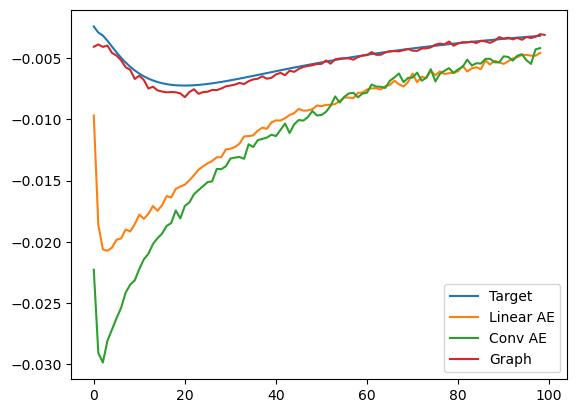

In [54]:
random_sample = int(np.random.rand()*len(data_set))

in_sample = data_set[random_sample][0]
in_sample_conv = data_set_conv[random_sample][0]
in_sample_graph = data_set_graph[random_sample]
in_sample_graph_idx = {}
in_sample_graph_idx["edge_index"] = in_sample_graph["edge_index"][None]
in_sample_graph_idx["node_feature"] = in_sample_graph["node_feature"][None]
in_sample_graph_idx["vectors"] = in_sample_graph["vectors"][None]
target_conv = data_set_conv[random_sample][1]
target = data_set[random_sample][1]
target_graph = data_set_graph[random_sample]["target"]
prediction = model.model(in_sample)
prediction_conv = model_conv.model(in_sample_conv[None,:,:])
prediction_graph = model_graph.model(in_sample_graph_idx)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    plt.figure(int(1000*np.random.rand()))
    # plt.plot(target_conv[100:199].cpu())
    plt.plot(target[100:199].cpu(), label="Target")
    plt.plot(prediction[100:199].detach().numpy(), label="Linear AE")
    plt.plot(prediction_conv[0,100:199].detach().numpy(), label="Conv AE")
    plt.plot(prediction_graph[:].detach().numpy(), label="Graph")
    plt.legend()


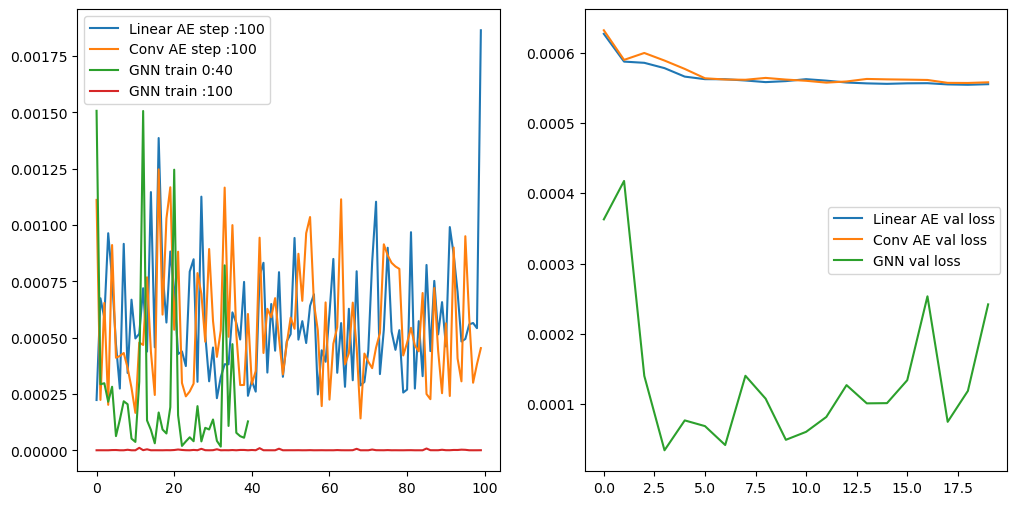

In [56]:
from tbparse import SummaryReader
log_dir = "../saves/save_GreenGNN_2023-12-17/8xA40/events.out.tfevents.1702853627.n3066-019.4045655.0"
reader = SummaryReader(log_dir)
df = reader.scalars
train_loss_gnn = df[df['tag'] == 'train_loss'].value
val_loss_gnn = df[df['tag'] == 'val_loss'].value
log_dir = "../saves/save_auto_encoder_2023-12-17/128xCPU/events.out.tfevents.1702849807.l53.vsc.xcat.1616104.0"
reader = SummaryReader(log_dir)
df = reader.scalars
train_loss_ae = df[df['tag'] == 'train_loss'].value
val_loss_ae = df[df['tag'] == 'val_loss'].value
log_dir = "../saves/save_auto_encoder_conv_2023-12-18/128xCPU/events.out.tfevents.1702890026.l51.vsc.xcat.146919.0"
reader = SummaryReader(log_dir)
df = reader.scalars
train_loss_ae_conv = df[df['tag'] == 'train_loss'].value
val_loss_ae_conv = df[df['tag'] == 'val_loss'].value


(fig,ax) = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(np.array(train_loss_ae[-100:]), label="Linear AE step :100")
ax[0].plot(np.array(train_loss_ae_conv[-100:]), label="Conv AE step :100")
ax[0].plot(np.array(train_loss_gnn[:40]), label="GNN train 0:40")
ax[0].plot(np.array(train_loss_gnn[-100:]), label="GNN train :100")
ax[0].legend()
ax[1].plot(np.array(val_loss_ae), label="Linear AE val loss")
ax[1].plot(np.array(val_loss_ae_conv), label="Conv AE val loss")
ax[1].plot(np.array(val_loss_gnn), label="GNN val loss")
ax[1].legend()

In [37]:
# # %pwd
# # %ls
# # from google.colab import drive
# # drive.mount('/content/drive/')
# # %cd ..//saves/save_GreenGNN_2023-12-14/version_0
# # %pwd
# # %ls
# %load_ext tensorboard/
# !tensorboard --logdir ../saves/save_GreenGNN_2023-12-17/version_3

# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# event_acc = EventAccumulator(evtf)
# event_acc.Reload()


# # def parse_tensorboard(path, scalars):
# #     """returns a dictionary of pandas dataframes for each requested scalar"""
# #     ea = event_accumulator.EventAccumulator(
# #         path,
# #         size_guidance={event_accumulator.SCALARS: 0},
# #     )
# #     print(ea)
# #     _absorb_print = ea.Reload()
# #     # make sure the scalars are in the event accumulator tags
# #     # assert all(
# #     #     s in ea.Tags()["tensors"] for s in scalars
# #     # ), "some scalars were not found in the event accumulator"
# #     # return {k: pd.DataFrame(ea.Tensors(k)) for k in scalars}

# # print(parse_tensorboard("../saves/saves/save_GreenGNN_2023-12-14/version_0/events.out.tfevents.1702573757.n3066-015.3397121.0", None))

In [38]:
%load_ext tensorboard
%tensorboard --logdir ../saves/saves/save_GreenGNN_2023-12-14/version_0/
# notebook.display(port=6006, height=1000) 
# # # !pip install jupyter-tensorboard
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances
# notebook.display(port=6006, height=1000) 
# !kill 1543469